# Observing Dark Worlds

## Goal
Observing Dark World is a astrophysics problem of detecting positions of dark matter halos by using its gravitational lensing effect, typically meas it destort the light of background galaxy which passes close to the Dark Matter.
It's a hard problem because detecting dark matter is difficult and it's hard to recognize the distortion.
![Gravitational_Lensing](images/reorderdarkmatter.png)

## Data
To predict the position of the core of dark matter, we gather 300 telescope scan data from kaggle, each telescope data contains 300 to 800 galaxy data. Each galaxy data are consist of x and y corrdinates and two ellipiticity data, represents the elongation of the galaxies, cased by the spacetime wrap from dark matter halos. (Salimans, 2012)

# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import tensorflow.contrib.distributions as ds
from edward.models import Normal, Uniform, InverseGamma, Empirical, Categorical, Mixture
from tensorflow.contrib import slim
from edward.util import Progbar

# Import Data
* all_sky_star = []: skies
    * all_sky_star[i]: one sky
        * all_sky_star[i][0]: galaxy name
        * all_sky_star[i][1]: galaxy x position
        * all_sky_star[i][2]: galaxy y position
        * all_sky_star[i][3]: galaxy e1
        * all_sky_star[i][4]: galaxy e2

* all_sky_halo = []:halos
    * all_sky_halo[i] :halo for sky i
        * all_sky_halo[i][0]: sky name
        * all_sky_halo[i][1]: number of halos
        * all_sky_halo[i][2]: halo1 x
        * all_sky_halo[i][3]: halo1 y
        * ...
        * all_sky_halo[i][7]: halo3 y

In [2]:
num_of_sky = 300
file_path = "datasets"
all_sky_star = []

for sky in np.arange(1, num_of_sky + 1, 1):
    sky_path = "Train_Skies/Training_Sky" + str(sky) + ".csv"
    halo_path = "Training_halos.csv"
    star = pd.read_csv(file_path + "/" + sky_path)
    all_sky_star.append(star.values)
star.head()
#all_sky_halo = all_sky_halo.values


,GalaxyID,x,y,e1,e2
0,Galaxy1,1630.16,1027.12,-0.194881,0.045802
1,Galaxy2,1056.72,126.24,-0.235309,0.176257
2,Galaxy3,3903.84,2612.56,0.213914,-0.052132
3,Galaxy4,2120.96,2098.82,0.272938,-0.045578
4,Galaxy5,1549.02,2042.28,-0.507234,0.086598


In [3]:
all_sky_halo_data = pd.read_csv(file_path + "/" + halo_path)
all_sky_halo = all_sky_halo_data.values
all_sky_halo_data.head()


,SkyId,numberHalos,x_ref,y_ref,halo_x1,halo_y1,halo_x2,halo_y2,halo_x3,halo_y3
0,Sky1,1,1086.80,1114.61,1086.80,1114.61,0.0,0.0,0.0,0.0
1,Sky2,1,3477.71,1907.33,3477.71,1907.33,0.0,0.0,0.0,0.0
2,Sky3,1,2315.78,1081.95,2315.78,1081.95,0.0,0.0,0.0,0.0
3,Sky4,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
4,Sky5,1,3091.65,2001.08,3091.65,2001.08,0.0,0.0,0.0,0.0


# Data Processing
## single_sky_data
* sky_num = []:    No. of test sky
* single_sky_halo_xy: 2d position of halo in test sky
* single_sky_e1[i]:   e1 of i_th galaxy in test sky
* single_sky_e2[i]:   e2 of i_th galaxy in test sky
* single_sky_a1[i]:   a1 of i_th galaxy in test sky
* single_sky_a2[i]:   a2 of i_th galaxy in test sky

In [105]:
sky_num = 2
single_sky_halo_xy = np.array(all_sky_halo[sky_num, 2:4], dtype=np.float32)
single_sky_e1 = np.array(all_sky_star[sky_num][:, 3], dtype=np.float32)
single_sky_e2 = np.array(all_sky_star[sky_num][:, 4], dtype=np.float32)
l2_e1e2 = np.sqrt(single_sky_e1**2 + single_sky_e2**2)
q = ((1. + l2_e1e2) / (1 - l2_e1e2))**2
single_sky_a1 = np.sqrt(q / (1 + q))
single_sky_b1 = np.sqrt(1. / (1 + q))
single_sky_pos_xy = np.array(all_sky_star[sky_num][:, 1:3])
num_of_glxy = single_sky_pos_xy.shape[0]

In [ ]:
all_sky_glxy_no = [0]
sky0_e1 = np.array(all_sky_star[0][:,3],dtype=np.float32)
sky0_e2 = np.array(all_sky_star[0][:,4],dtype=np.float32)
sq = np.sqrt(sky0_e1**2+sky0_e2**2)
q = ((1.+sq)/(1-sq))**2
sky0_a1 = np.sqrt(q/(1+q))
sky0_b1 = np.sqrt(1./(1+q))
select = sky0_a1/sky0_b1>-100
select = select.reshape(select.shape[0])
conc_glxy_xy = all_sky_star[0][select,1:3]
conc_halo_xy = np.ones(all_sky_star[0][select,1:3].shape)*all_sky_halo[0,2:4]
conc_glxy_e1_e2 = all_sky_star[0][select,3:5]
all_sky_glxy_no.append(conc_glxy_xy.shape[0])

for sky2 in np.arange(1,300,1):
    e1,e2 = np.array(all_sky_star[sky2][:,3:4],dtype=np.float32),np.array(all_sky_star[sky2][:,4:5],dtype=np.float32)
    sq = np.sqrt(e1**2+e2**2)
    q = ((1.+sq)/(1-sq))**2
    a1 = np.sqrt(q/(1+q))
    b1 = np.sqrt(1./(1+q))
    select = a1/b1>-100
    select = select.reshape(select.shape[0])
    conc_glxy_xy = np.concatenate((conc_glxy_xy,all_sky_star[sky2][select,1:3]),axis = 0)
    conc_glxy_e1_e2 = np.concatenate((conc_glxy_e1_e2,all_sky_star[sky2][select,3:5]),axis = 0)    
    conc_halo_xy = np.concatenate((conc_halo_xy,np.ones(all_sky_star[sky2][select,1:3].shape)*all_sky_halo[sky2,2:4]),axis = 0)
    all_sky_glxy_no.append(conc_glxy_xy.shape[0])
print(conc_glxy_xy.shape)
print(conc_halo_xy.shape)
print(conc_glxy_e1_e2.shape)
num_all_glxy = conc_glxy_xy.shape[0]
# print(all_sky_glxy_no)

# Distribution of Galaxies

After looking into how ellipiticity is distributed among all skies, we believe that $e1$ and $e2$ should be $Normal$ distribution where $\mu=0, \sigma^2=0.046$ in general.

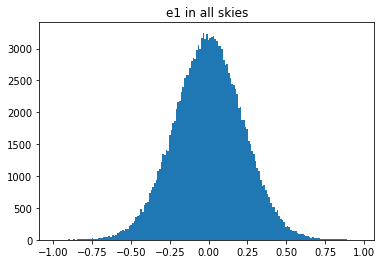

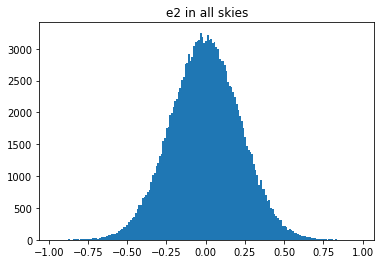

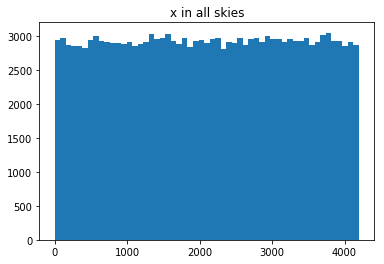

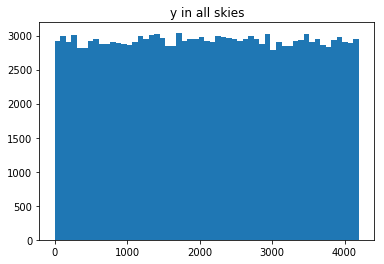

In [113]:
plt.clf()
plt.title("e1 in all skies")
plt.hist(conc_glxy_e1_e2[:, 0].tolist(), bins='auto')
plt.show()
plt.clf()
plt.title("e2 in all skies")
plt.hist(conc_glxy_e1_e2[:, 1].tolist(), bins='auto')
plt.show()
plt.clf()
plt.title("x in all skies")
plt.hist(conc_glxy_xy[:, 0].tolist(), bins='auto')
plt.show()
plt.clf()
plt.title("y in all skies")
plt.hist(conc_glxy_xy[:, 1].tolist(), bins='auto')
plt.show()

# Univariate Gaussian Model

Our first straight-forward univariate gaussian model is that each galaxy $(x, y, e1, e2)$ is generated from

* $x, y = Uniform(0, 4200)$
* $e1, e2 = Normal(e_{tangential}, \sigma^2)$

where $e_{tangential}$ is the normal vector from the galaxy to the true halo. And we want to infer the latant variable is the position of the true halo $halo\_pos\_xy$ from observed data $(x, y, e1, e2)$. In our first model, $\sigma^2$ is fixed to $0.046$ after observing the training data.

We simply set the prior $halo\_pos\_xy = Uniform(0, 4200)$ because we haven't found any prior knowledge of the true halo now.

In [107]:
def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:, 1], delta[:, 0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

N = num_of_glxy
glxy_pos_xy = tf.placeholder(tf.float32, [N, 2])
halo_pos_xy = Uniform(low=[0., 0.], high=[4200., 4200.])
# halo_pos_xy = Normal(loc=tf.constant([2100., 2100.]), scale=tf.constant(20.0))
sigma = tf.constant(.046)  # InverseGamma(20.0, 1.0)
l2diff_halo_glxy = tf.sqrt(tf.reduce_sum(tf.square(glxy_pos_xy - halo_pos_xy),
                           reduction_indices=1))
sess = ed.get_session()
glxy_e1 = Normal(loc=tangential(glxy_pos_xy, halo_pos_xy, 0), scale=sigma)
glxy_e2 = Normal(loc=tangential(glxy_pos_xy, halo_pos_xy, 1), scale=sigma)

# Inference

## MCMC

We use SGHMC to sample from posterior distribution of position of halo. We tried to sample from a random starting point and tune step size to make it converge fast.

In [108]:
# Inference
def constraints_normal(T):
    return tf.minimum(tf.maximum(tf.Variable(tf.random_normal([T, 2],
                      mean=[2100., 2100.], stddev=100.)), 0), 4200)
e1_in = single_sky_e1.reshape(N).tolist()
e2_in = single_sky_e2.reshape(N).tolist()

T = 3000
q_halo_pos_xy = Empirical(params=constraints_normal(T))
# qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
inference = ed.SGHMC({halo_pos_xy: q_halo_pos_xy},
                     data={glxy_pos_xy: single_sky_pos_xy,
                     glxy_e1: e1_in, glxy_e2: e2_in})
inference.run(step_size=5.)

3000/3000 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.000


# Criticism

Now print out samples drawn from posterior and compare it to the true halo.

[ 2339.38061523  1173.83703613] [ 10.93104458  97.90337372]
prediction from stable sample:  (2340.7236, 1162.6727)
mean distantance to true halo: 84.4887203984


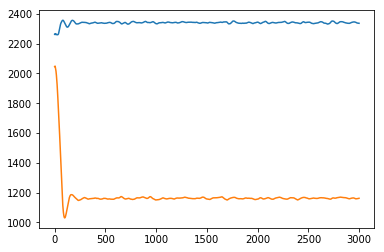

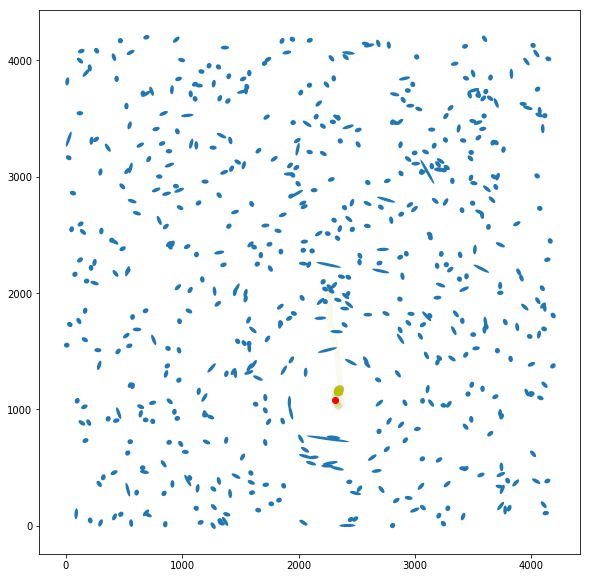

In [109]:
def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i, :]
        x, y = _g[0], _g[1]
        d = np.sqrt(_g[2]**2 + _g[3]**2)
        a = 1.0 / (1 - d)
        b = 1.0 / (1 + d)
        theta = np.degrees(np.arctan2(_g[3], _g[2]) * 0.5)
        ax.add_patch(Ellipse(xy=(x, y), width=size_multiplier * a,
                     height=size_multiplier * b, angle=theta))
    ax.autoscale_view(tight=True)
    return fig

mean, stddev = sess.run([q_halo_pos_xy.mean(), q_halo_pos_xy.stddev()])
print(mean, stddev)
samples = sess.run(q_halo_pos_xy.params)
pred = samples[-500:, 0].mean(), samples[-500:, 1].mean()
print('prediction from stable sample: ', pred)
print('mean distantance to true halo:', np.sqrt(np.sum((all_sky_halo[sky_num, 2:4] - pred) ** 2)))

# plt.hist(samples, bins='auto')
# plt.show()

# Trace plot.
plt.plot(samples)
plt.show()
plt.clf()
fig = draw_sky(all_sky_star[sky_num][:, 1:])
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.015, c="y")
plt.scatter(all_sky_halo[sky_num, 2], all_sky_halo[sky_num, 3], c="r")
plt.show()


After a short period burn-in time, our sample converges to one mode which is quite close to the true halo. One metric we use to evaluate how good our prediction is the euclidean distance to the true halo. 

# Criticism 2

Because HMC is sensitive to initial value, we may want to try different settings of our initial guess.

3000/3000 [100%] ██████████████████████████████ Elapsed: 10s | Acceptance Rate: 1.000
[ 2243.95556641  1138.13537598] [ 358.6701355  227.1583252]
3000/3000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 1.000
[ 2275.77124023  1210.63464355] [ 298.45257568   31.00737572]
3000/3000 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.000
[ 2257.42456055  1261.59765625] [ 337.16680908  220.67985535]
3000/3000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 1.000
[  905.04266357  3163.9597168 ] [ 81.71781158  67.2808075 ]
3000/3000 [100%] ██████████████████████████████ Elapsed: 10s | Acceptance Rate: 1.000
[ 2322.36425781  1184.95324707] [ 111.49421692  114.19600677]
3000/3000 [100%] ██████████████████████████████ Elapsed: 11s | Acceptance Rate: 1.000
[ 2325.65600586  1207.46240234] [ 105.15981293   25.94026184]
3000/3000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 1.000
[ 2314.50268555  1234.7565918 ] [ 

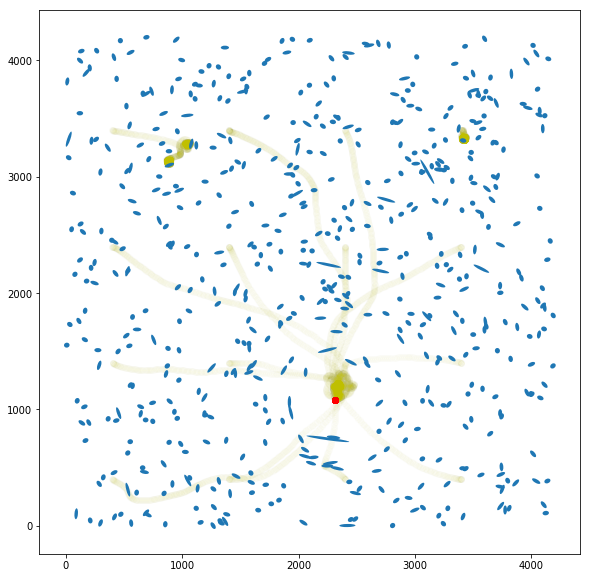

In [143]:
plt.clf()
fig = draw_sky(all_sky_star[sky_num][:, 1:])
for i in np.arange(400, 4001, 1000):
    for j in np.arange(400, 4001, 1000):
        def constraints_normal(T):
            return tf.minimum(tf.maximum(tf.Variable(tf.random_normal(
                              [T, 2], mean=[i, j], stddev=1.)), 0), 4200)

        T = 3000
        q_halo_pos_xy = Empirical(params=constraints_normal(T))
        # qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
        inference = ed.SGHMC({halo_pos_xy: q_halo_pos_xy},
                             data={glxy_pos_xy: single_sky_pos_xy,
                             glxy_e1: e1_in, glxy_e2: e2_in})
        inference.run(step_size=5.)

        mean, stddev = sess.run([q_halo_pos_xy.mean(), q_halo_pos_xy.stddev()])
        print(mean, stddev)
        samples = sess.run(q_halo_pos_xy.params)
        # plt.hist(samples, bins='auto')
        # plt.show()

        # Trace plot.
        # plt.plot(samples)
        # plt.show()

        plt.scatter(samples[0:, 0], samples[0:, 1], alpha=0.015, c="y")
        plt.scatter(all_sky_halo[sky_num, 2], all_sky_halo[sky_num, 3], c="r")
plt.show()


# Univariate Gaussian Model 2

After running our first model on test data, we find that our first model may converge to a position far from the true halo when galaxy gets more noisy. This is because that in our first model, galaxies near to and far from the halo are treated equally. However, the number of galaxies is increased at a speed $\propto r$ to the halo so that the number of galaxies far from halo is much more than galaxies near to halo. We know that near halo galaxies are stronger singal compared to large amount of noise from far halo galaxies.

In our second model, we want to decrease influence of noise introduced by imbalanced training data by adding a dropoff factor $mu \propto 1/r$ to $e1, e2$ so that we could treat those far halo galaxies as noise. Furthermore, we find that  making $\sigma$ a Inverse-Gamma prior instead of fixing it at some value may lead to strong instability when doing inference. We try to assume linear relationship between $\sigma$ and $r$ to see that if we could get better prediction. 

In this model, 
* $m = InverseGamma(1.0, 1.0)$
* $e1, e2 = Normal(e_{tan} * m / r, \sigma^2)$

In [110]:
def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:, 1], delta[:, 0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

N = num_of_glxy
glxy_pos_xy = tf.placeholder(tf.float32, [N, 2])
halo_pos_xy = Uniform(low=[0., 0.], high=[4200., 4200.])
l2diff_halo_glxy = tf.sqrt(tf.reduce_sum(tf.square(glxy_pos_xy - halo_pos_xy),
                           reduction_indices=1))

sigma = tf.minimum(tf.maximum(tf.constant(.0965) - l2diff_halo_glxy * .000058, .040), .082)
m = InverseGamma(1.0, 1.0)
mu = tf.minimum(tf.maximum(m * 150, 50.), 240.) / tf.maximum(l2diff_halo_glxy, 240.)
sess = ed.get_session()
glxy_e1 = Normal(loc=tangential(glxy_pos_xy, halo_pos_xy, 0) * mu, scale=sigma)
glxy_e2 = Normal(loc=tangential(glxy_pos_xy, halo_pos_xy, 1) * mu, scale=sigma)

In [111]:
# Inference
def constraints_normal(T):
    return tf.minimum(tf.maximum(tf.Variable(tf.random_normal([T, 2],
                      mean=[2100., 1300.], stddev=100.)), 0), 4200)
e1_in = single_sky_e1.reshape(N).tolist()
e2_in = single_sky_e2.reshape(N).tolist()

T = 1500
q_halo_pos_xy = Empirical(params=constraints_normal(T))
qm = Empirical(params=tf.Variable(tf.random_uniform([T], 150., 300.)))
inference = ed.HMC({halo_pos_xy: q_halo_pos_xy,
                     m: qm},
                     data={glxy_pos_xy: single_sky_pos_xy,
                     glxy_e1: e1_in, glxy_e2: e2_in})
inference.run(step_size=.5)

1500/1500 [100%] ██████████████████████████████ Elapsed: 17s | Acceptance Rate: 0.999


[ 2321.24194336  1153.55664062] [ 27.92538452  13.27830124]
prediction from stable sample:  (2329.0095, 1152.9272)
mean distantance to true halo: 72.1996516734


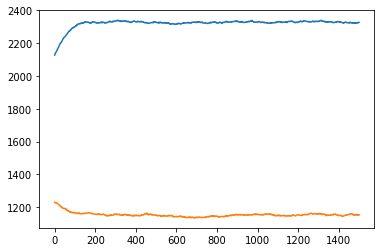

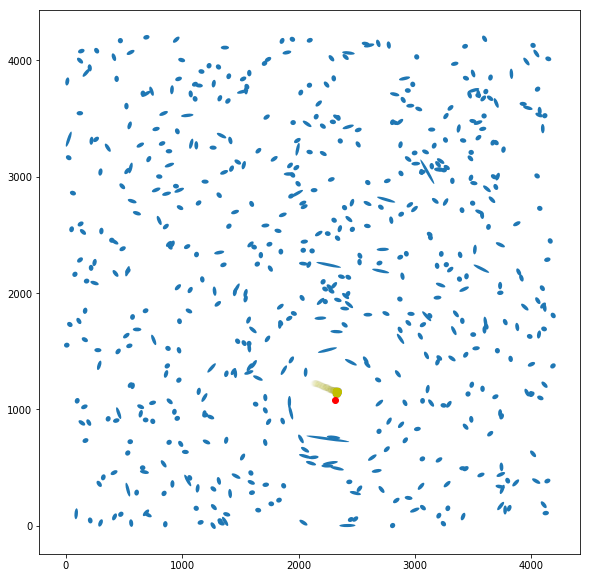

In [112]:
# Criticism

def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i, :]
        x, y = _g[0], _g[1]
        d = np.sqrt(_g[2]**2 + _g[3]**2)
        a = 1.0 / (1 - d)
        b = 1.0 / (1 + d)
        theta = np.degrees(np.arctan2(_g[3], _g[2]) * 0.5)
        ax.add_patch(Ellipse(xy=(x, y), width=size_multiplier * a,
                     height=size_multiplier * b, angle=theta))
    ax.autoscale_view(tight=True)
    return fig

mean, stddev = sess.run([q_halo_pos_xy.mean(), q_halo_pos_xy.stddev()])
print(mean, stddev)
# print(sess.run(qm.params))
samples = sess.run(q_halo_pos_xy.params)
pred = samples[-500:, 0].mean(), samples[-500:, 1].mean()
print('prediction from stable sample: ', pred)
print('mean distantance to true halo:', np.sqrt(np.sum((all_sky_halo[sky_num, 2:4] - pred) ** 2)))

# plt.hist(samples, bins='auto')
# plt.show()

# Trace plot.
plt.plot(samples)
plt.show()
plt.clf()
fig = draw_sky(all_sky_star[sky_num][:, 1:])
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.015, c="y")
plt.scatter(all_sky_halo[sky_num, 2], all_sky_halo[sky_num, 3], c="r")
plt.show()


Comparing to our first model, our second model treat near galaxies much more important than far galaxies. This could give us a better prediction but more likely to sample into suboptimal modes. We could combine model I to generate burn-in samples for model II to improve overall performance, but next we'll try a different apporach instead.

# Mixture Density Network

## Motivation

Given each galaxy $(x1, x2, e1, e2)$, we want to calculate $P(\theta=(\rho, \phi) | X, E)$. For each galaxy, the posterior is a multimodal distribution function in the whole sky. In our previous model, we have assumed that the probability function is a singlemodal Gaussian. In this model, we tried mixture density network to approximate multimodal $P(\theta|X,E)$ using trainned Bayesian Neurual Network to get our mixture components.

## Data Preparation

We'll calculate $(\rho, \phi)$ for each galaxy and concatenate training data of all skies into one sky to train our neurual network.

In [162]:
all_sky_xy_e1e2 = np.concatenate((conc_glxy_xy/4200., conc_glxy_e1_e2),axis = 1)
conc_glxy_halo_d_xy = (conc_glxy_xy - conc_halo_xy)/4200.
all_sky_glxy_halo_r = (np.sum(conc_glxy_halo_d_xy**2 ,axis = 1))**(1/2.)
#all_sky_glxy_halo_p = np.arctan2(conc_glxy_halo_d_xy[:,0].astype(dtype = np.float64),conc_glxy_halo_d_xy[:,1].astype(dtype = np.float64))
all_sky_glxy_halo_p = np.arctan(conc_glxy_halo_d_xy[:,1].astype(dtype = np.float64)/conc_glxy_halo_d_xy[:,0].astype(dtype = np.float64))
print(all_sky_glxy_halo_p)

[ 1.21057721 -1.36015632 -0.4846697  ..., -1.40583051  0.9180103
  1.36840944]


## Data Resampling

Due to significant imbalance of galaxies distributed to halo with respect to distance, we resampled our training galaxies to make sure galaxies of different distances have the same priority. 

(160842, 6)
(3563, 6)
(5604, 6)
(7280, 6)
(8552, 6)
(9674, 6)
(10508, 6)
(11039, 6)
(11453, 6)
(11514, 6)
(11497, 6)
(10831, 6)
(10168, 6)
(9297, 6)
(8473, 6)
(7434, 6)
(6444, 6)
(5429, 6)
(3979, 6)
(2815, 6)
(1768, 6)
(200021, 6)


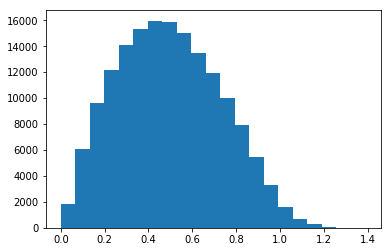

In [211]:

all_sky_xy_e1e2_r_p = np.concatenate((all_sky_xy_e1e2,all_sky_glxy_halo_r.reshape(all_sky_glxy_halo_r.shape[0],1)),axis=1)
all_sky_xy_e1e2_r_p = np.concatenate((all_sky_xy_e1e2_r_p,all_sky_glxy_halo_p.reshape(all_sky_glxy_halo_p.shape[0],1)),axis=1)
print(all_sky_xy_e1e2_r_p.shape)
# for i np.arange(0,)
l = all_sky_xy_e1e2_r_p[0].reshape(1,6)
select = all_sky_xy_e1e2_r_p[:,4]<200/4200.
for i in np.arange(240,4200,200):
    select_low = all_sky_xy_e1e2_r_p[:,4]>(i/4200.)
    select_hi = all_sky_xy_e1e2_r_p[:,4]<(i+200)/4200.
    select = select_low & select_hi
    sample = all_sky_xy_e1e2_r_p[select]
    l2 = sample[0].reshape(1,6)
    for j in range(5000):
        ran = np.random.randint(0,sample.shape[0])
        sam = sample[ran]
        if sam[5]>0:
            l2 = np.concatenate((l2, sam.reshape(1,6)))
            sam[5] = sam[5]-np.pi
            l2 = np.concatenate((l2, sam.reshape(1,6)))
        else:
            l2 = np.concatenate((l2, sam.reshape(1,6)))
            sam[5] = sam[5]+np.pi
            l2 = np.concatenate((l2, sam.reshape(1,6)))
    l = np.concatenate((l, l2))   
    print(sample.shape)
#test = all_sky_xy_e1e2_r_p[select]
print(l.shape)
#print(test.shape)
plt.hist(all_sky_glxy_halo_r.tolist(),21)
plt.show()

sample_all_sky_xy_e1e2 = l[:,:4]
sample_all_sky_glxy_halo_r = l[:,4]
sample_all_sky_glxy_halo_p = l[:,5]
#

# sample_all_sky_xy_e1e2 = np.concatenate((sample_all_sky_xy_e1e2,sample_all_sky_xy_e1e2))
# sample_all_sky_glxy_halo_r = np.concatenate((sample_all_sky_glxy_halo_r,sample_all_sky_glxy_halo_r))
# sample_all_sky_glxy_halo_p = np.concatenate((sample_all_sky_glxy_halo_p,np.mod((sample_all_sky_glxy_halo_p+(np.pi)),np.pi)))
# print(sample_all_sky_xy_e1e2.shape)

In [214]:
# plt.hist(sample_all_sky_glxy_halo_r.tolist(),21)
# plt.show()
# plt.hist(all_sky_glxy_halo_r.tolist(),21)
# plt.show()
print(l[500:])

[[0.6553595238095239 0.6313309523809524 0.103523 0.161687
  0.07070694350210896 -0.6690823121134556]
 [0.6553595238095239 0.6313309523809524 0.103523 0.161687
  0.07070694350210896 2.4725103414763376]
 [0.7901095238095238 0.4781785714285714 -0.132176 0.057445
  0.08880839128602534 -1.0029608558929313]
 ..., 
 [0.9944357142857143 0.12319285714285713 -0.290417 0.019842
  1.0034998259605967 -0.6105257581989423]
 [0.43324761904761905 0.9706571428571429 0.037739 0.079696
  0.9808312077378872 -1.2467413212485887]
 [0.43324761904761905 0.9706571428571429 0.037739 0.079696
  0.9808312077378872 1.8948513323412044]]


## Neural Network
We try to train a 2-layer neural network with 200 and 50 hidden units. Our MDN have 4 mixture components, each of them is a $Normal$ distribution.

In [215]:
N = num_all_glxy
in_data = tf.placeholder(tf.float32, [None, 4],name = "in")
out_r = tf.placeholder(tf.float32, [None])
out_p = tf.placeholder(tf.float32, [None])
def neural_network(input_x):
    hidden1 = slim.fully_connected(input_x, 200)
    hidden2 = slim.fully_connected(hidden1, 50)
#     locs_r = slim.fully_connected(hidden2, K, activation_fn=None)
#     scales_r = slim.fully_connected(hidden2, K, activation_fn=tf.exp)
#     logits_r = slim.fully_connected(hidden2, K, activation_fn=None)
    locs_p = slim.fully_connected(hidden2, K, activation_fn=None)
    scales_p = slim.fully_connected(hidden2, K, activation_fn=tf.exp)
    logits_p = slim.fully_connected(hidden2, K, activation_fn=None)
    # return locs_r, scales_r, logits_r, locs_p, scales_p, logits_p
    return locs_p, scales_p, logits_p

K = 4

# locs_r, scales_r, logits_r, 
locs_p, scales_p, logits_p = neural_network(in_data)
# cat_r = Categorical(logits=logits_r)
# components_r = [Normal(loc=loc, scale=scale) for loc, scale
#               in zip(tf.unstack(tf.transpose(locs_r)),
#                      tf.unstack(tf.transpose(scales_r)))]
# r = Mixture(cat=cat_r, components=components_r, value=tf.zeros_like(out_r))
cat_p = Categorical(logits=logits_p)
cat_p = Categorical(logits=logits_p)
components_p = [Normal(loc=loc, scale=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs_p)),
                     tf.unstack(tf.transpose(scales_p)))]
p = Mixture(cat=cat_p, components=components_p, value=tf.zeros_like(out_p))

# Inference

We use MAP to do inference of our neurual network. Our neural network converges after ~300 epochs.

In [216]:
#inference = ed.MAP(data={r: out_r, p:out_p})
inference = ed.MAP(data={p:out_p})
optimizer = tf.train.AdamOptimizer(5e-3)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

sess = ed.get_session()
tf.global_variables_initializer().run()

In [217]:
# train on only p
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={in_data: sample_all_sky_xy_e1e2,out_p: sample_all_sky_glxy_halo_p })
  train_loss[i] = info_dict['loss']
  #test_loss[i] = sess.run(inference.loss, feed_dict={in_data: sample_all_sky_xy_e1e2,out_p: sample_all_sky_glxy_halo_p })
  inference.print_progress(info_dict)

 300/1000 [ 30%] █████████                      ETA: 823s | Loss: 328726.219

In [18]:
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={in_data: all_sky_xy_e1e2, out_r: all_sky_glxy_halo_r,out_p: all_sky_glxy_halo_p })
  train_loss[i] = info_dict['loss']
  test_loss[i] = sess.run(inference.loss, feed_dict={in_data: all_sky_xy_e1e2, out_r: all_sky_glxy_halo_r,out_p: all_sky_glxy_halo_p })
  inference.print_progress(info_dict)

 300/1000 [ 30%] █████████                      ETA: 596s | Loss: 74165.297

In [13]:
# train on resampled data
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={in_data: sample_all_sky_xy_e1e2, out_r: sample_all_sky_glxy_halo_r,out_p: sample_all_sky_glxy_halo_p })
  train_loss[i] = info_dict['loss']
  test_loss[i] = sess.run(inference.loss, feed_dict={in_data: sample_all_sky_xy_e1e2, out_r: sample_all_sky_glxy_halo_r,out_p: sample_all_sky_glxy_halo_p })
  inference.print_progress(info_dict)

 300/1000 [ 30%] █████████                      ETA: 595s | Loss: 74545.562

In [23]:
#train on near data
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
select =all_sky_glxy_halo_r<1500/4200.
near_all_sky_xy_e1e2 = all_sky_xy_e1e2[select,:]
near_all_sky_glxy_halo_r = all_sky_glxy_halo_r[select]
near_all_sky_glxy_halo_p =all_sky_glxy_halo_p[select]
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={in_data: near_all_sky_xy_e1e2, out_r: near_all_sky_glxy_halo_r,out_p: near_all_sky_glxy_halo_p })
  train_loss[i] = info_dict['loss']
  inference.print_progress(info_dict)
# print(near_all_sky_xy_e1e2)

 300/1000 [ 30%] █████████                      ETA: 226s | Loss: 857.734 

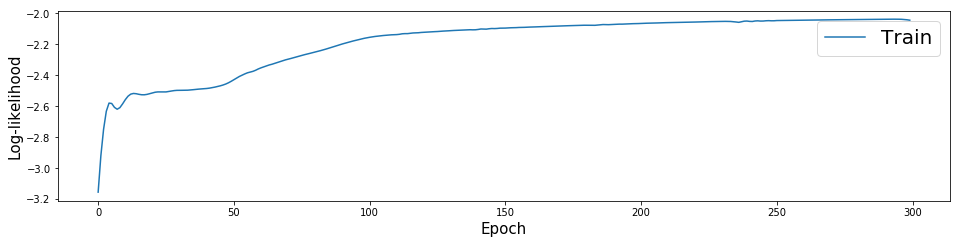

In [218]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
#plt.plot(np.arange(n_epoch), -test_loss , label='Test')
plt.plot(np.arange(n_epoch), -train_loss/N , label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()

In [219]:
# pred_weights_r, pred_means_r, pred_std_r = sess.run(
#     [tf.nn.softmax(logits_r), locs_r, scales_r], feed_dict={in_data: all_sky_xy_e1e2[all_sky_glxy_no[2]:all_sky_glxy_no[3],:]})
feed_dat = all_sky_xy_e1e2[all_sky_glxy_no[2]:all_sky_glxy_no[3],:]
select = (feed_dat[:,2]**2+feed_dat[:,3]**2)>1/15.
select2 = all_sky_glxy_halo_r[all_sky_glxy_no[2]:all_sky_glxy_no[3]]<0.2

print(select2.shape)
#print(select)
feed_dat_sel = feed_dat[select2]
print(feed_dat_sel.shape)
#print(feed_dat_sel)
pred_weights_p, pred_means_p, pred_std_p = sess.run(
    [tf.nn.softmax(logits_p), locs_p, scales_p], feed_dict={in_data: feed_dat_sel})
#print(feed_dat*4200)
# print(all_sky_xy_e1e2*4200.)
# print(all_sky_xy_e1e2[all_sky_glxy_no[2]]*4200.)
# print(all_sky_xy_e1e2[2]*4200.)
# print(all_sky_glxy_no[1])

(578,)
(60, 4)


In [220]:
pred_weights_r.shape[0]
# r_list = []
pbar = Progbar(60)
# for i in range(300):
#     pbar.update(i)
#     components_r = [Normal(loc=loc, scale=scale) for loc, scale
#                     in zip(tf.unstack(tf.transpose(pred_means_r[i])),
#                      tf.unstack(tf.transpose(pred_std_r[i])))]
#     cat_r = Categorical(logits=pred_weights_r[i])
#     r = Mixture(cat=cat_r, components=components_r, value=tf.zeros_like(out_r[i]))
#     r_list.append(r)
# logprob = 0.
# r.prob(1.).eval()
pred_weights_p.shape[0]
p_list = []
for i in range(60):
    pbar.update(1+i)
    components_p = [Normal(loc=loc, scale=scale) for loc, scale
                    in zip(tf.unstack(tf.transpose(pred_means_p[i])),
                     tf.unstack(tf.transpose(pred_std_p[i])))]
    cat_p = Categorical(logits=pred_weights_p[i])
    p= Mixture(cat=cat_p, components=components_p, value=tf.zeros_like(out_p[i]))
    p_list.append(p)


60/60 [100%] ██████████████████████████████ Elapsed: 8s


In [170]:
def r_t_glxy_halo(glxy_xy,halo_xy):
    extended_halo_xy = np.ones(glxy_xy.shape)*halo_xy
    distance = glxy_xy-halo_xy
    r = (np.sum(distance**2,axis = 1))**(1/2.)
    p = np.arctan((distance[:,0]/distance[:,1]).astype(dtype = np.float64))
    return r,p
print(r_t_glxy_halo(np.array([[1.,1.],[1.,2.],[2.,2.]]),np.array([0.,0.])))

(array([ 1.41421356,  2.23606798,  2.82842712]), array([ 0.78539816,  0.46364761,  0.78539816]))


# Inference

Posterior $P(\phi|x,e)$ checks from $-\pi$ to $\pi$. Our MDN model has successfully learned the two modal $-\pi/2$ and $\pi/2$ from our training data.

(126,) (126,)


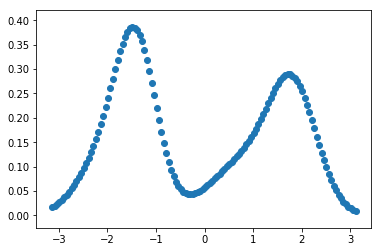

[2272.28 540.04 2618.931 902.9118]


In [221]:
g = 0
a = np.arange(-3.14,3.14,0.05)
b = p_list[g].prob(a.tolist()).eval()
print(a.shape, b.shape)
plt.scatter(a.tolist(), b.tolist())
plt.show()
s = all_sky_xy_e1e2[all_sky_glxy_no[2]:all_sky_glxy_no[3]]
print(feed_dat_sel[g]*4200.)
# print(r_list[0].prob(1. ).eval())

In [ ]:
print(r_list[1].prob([[0.1,0.2],[0.3,0.4]]).eval())

To visuallize posterior of the full sky using all test galaxies, we create $210*210$ bins and calculate sum of log likelihood in each bins.

In [172]:
def create_grid(halo_step):
    l = []
    for i in np.arange(int(halo_step/2), 4200, halo_step):
        l2 = []
        for j in np.arange(int(halo_step/2), 4200, halo_step):
            l2.append([i,j])
        l.append(l2)
    return l
grid_20 = np.array(create_grid(20))
dis = np.array(create_grid(20))

def grid_glxy_l2diff(grid, glxy_xy):
    distance = grid - glxy_xy
    l2diff_mat = (np.sum(distance**2,axis=2))**(1/2)
    return l2diff_mat

def grid_glxy_arctan(grid, glxy_xy):
    distance = grid - glxy_xy
    return np.arctan((distance[:,:,1]/distance[:,:,0]).astype(dtype = np.float64))

def grid_glxy_arctan2(grid, glxy_xy):
    distance = grid - glxy_xy
    return np.arctan2(distance[:,:,1].astype(dtype = np.float64),distance[:,:,0].astype(dtype = np.float64))


ata = grid_glxy_arctan(grid_20, [0., 0.])
print(ata.shape)

(210, 210)


## Predicted distribution of halo using only one galaxy

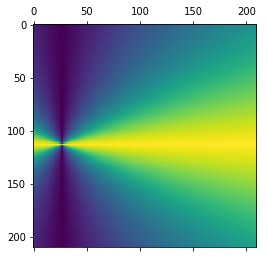

[2272.28 540.04]


In [222]:
g = 0
dis = grid_glxy_l2diff(grid_20, feed_dat_sel[g,0:2])/4200.
#atan = grid_glxy_arctan(grid_20, all_sky_star[2][g][1:3])
atan = np.abs(grid_glxy_arctan(grid_20, feed_dat_sel[g,0:2]*4200))
b2d = r_list[g].prob(dis.tolist()).eval()
c2d = p_list[g].prob(atan.tolist()).eval()
#print(a.shape, b.shape)
plt.matshow(c2d)
#plt.savefig("what.pdf")
plt.show()
#print(all_sky_star[2][g][1:3])
print(feed_dat_sel[g,0:2]*4200.)

## Predicted distribution of halo using all galaxies

  0/300 [  0%]                                ETA: 0s

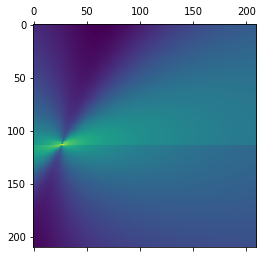

  1/300 [  0%]                                ETA: 3875s

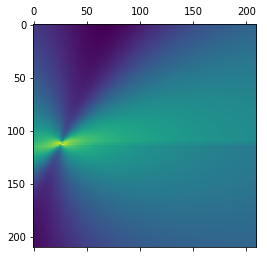

  2/300 [  0%]                                ETA: 3938s

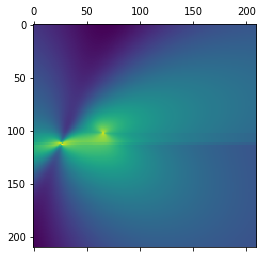

  3/300 [  1%]                                ETA: 4051s

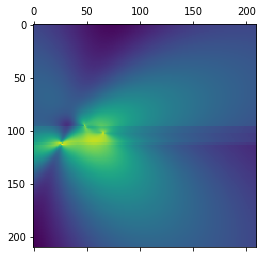

  4/300 [  1%]                                ETA: 4006s

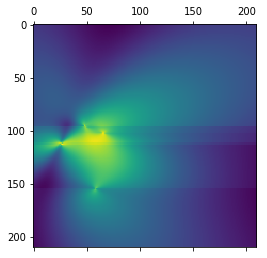

  5/300 [  1%]                                ETA: 3886s

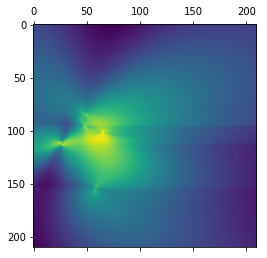

  6/300 [  2%]                                ETA: 3915s

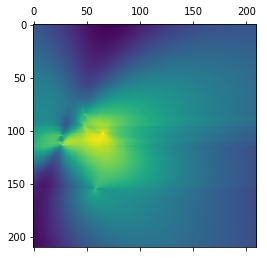

  7/300 [  2%]                                ETA: 3918s

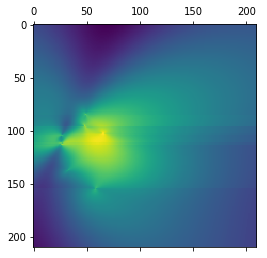

  8/300 [  2%]                                ETA: 3885s

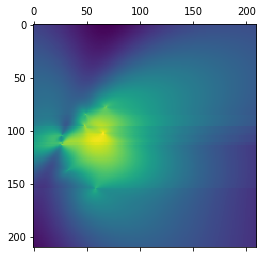

  9/300 [  3%]                                ETA: 3856s

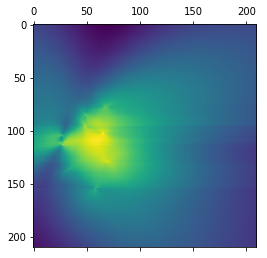

 10/300 [  3%] █                              ETA: 3797s

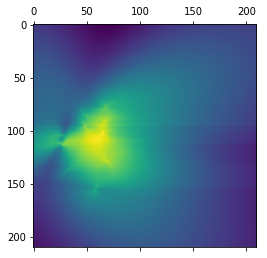

 11/300 [  3%] █                              ETA: 3742s

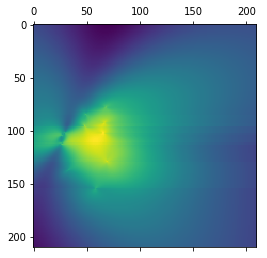

 12/300 [  4%] █                              ETA: 3695s

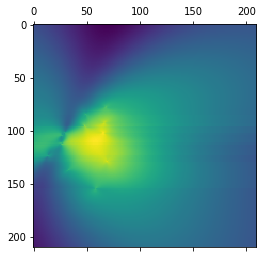

 13/300 [  4%] █                              ETA: 3655s

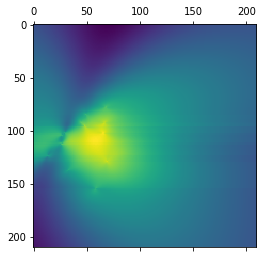

 14/300 [  4%] █                              ETA: 3645s

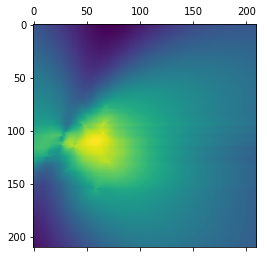

 15/300 [  5%] █                              ETA: 3614s

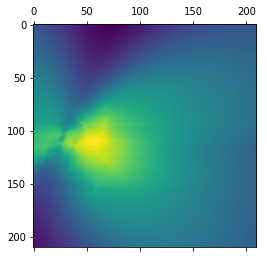

 16/300 [  5%] █                              ETA: 3581s

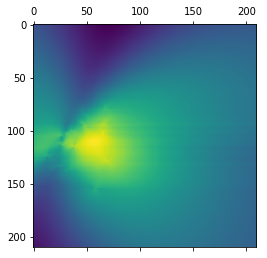

 17/300 [  5%] █                              ETA: 3560s

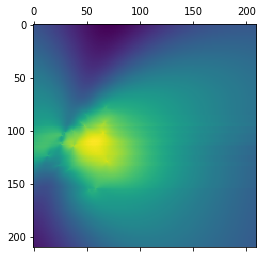

 18/300 [  6%] █                              ETA: 3553s

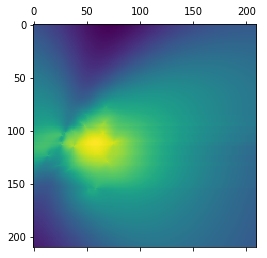

 19/300 [  6%] █                              ETA: 3546s

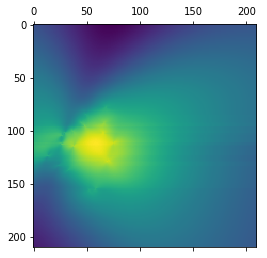

 20/300 [  6%] ██                             ETA: 3521s

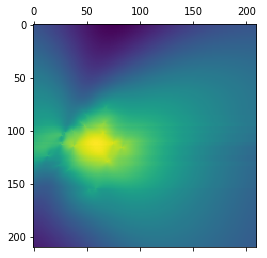

 21/300 [  7%] ██                             ETA: 3495s

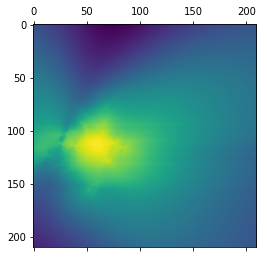

 22/300 [  7%] ██                             ETA: 3476s

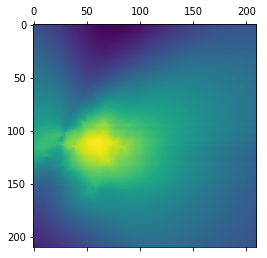

 23/300 [  7%] ██                             ETA: 3475s

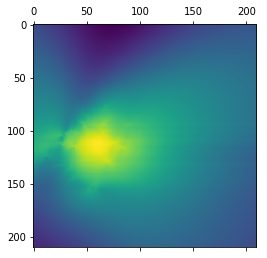

 24/300 [  8%] ██                             ETA: 3475s

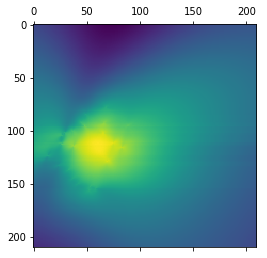

 25/300 [  8%] ██                             ETA: 3470s

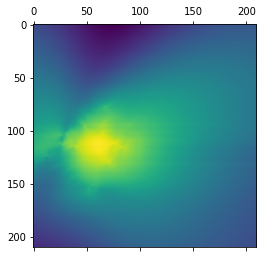

 26/300 [  8%] ██                             ETA: 3461s

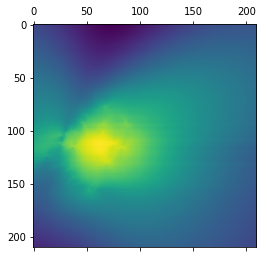

 27/300 [  9%] ██                             ETA: 3454s

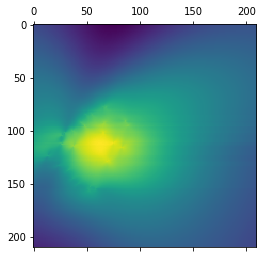

 28/300 [  9%] ██                             ETA: 3444s

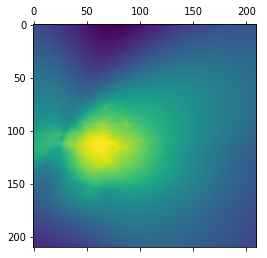

 29/300 [  9%] ██                             ETA: 3433s

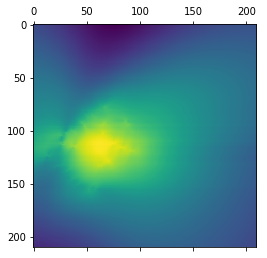

 30/300 [ 10%] ███                            ETA: 3421s

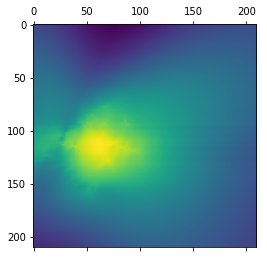

 31/300 [ 10%] ███                            ETA: 3416s

KeyboardInterrupt: 

In [223]:
#i = 0
prob = np.zeros(grid_20.shape[0])
pbar = Progbar(300)
for i in range(300):
    pbar.update(i)
    # dis = (grid_glxy_l2diff(grid_20, all_sky_star[2][i][1:3])/4200.).astype(np.float32)
    dis = (grid_glxy_l2diff(grid_20, feed_dat_sel[i,0:2]*4200.)/4200.).astype(np.float32)
    #atan = grid_glxy_arctan(grid_20, all_sky_star[2][i][1:3])
    atan = grid_glxy_arctan(grid_20, feed_dat_sel[i,0:2]*4200.)
    #b2d = np.log(r_list[i].prob(dis.tolist()).eval())
    c2d = np.log(p_list[i].prob(atan.tolist()).eval()*dis**(-1/2.))
#    prob=prob+b2d
    prob=prob+c2d
    plt.clf()
#print(a.shape, b.shape)
    plt.matshow(prob)
#plt.savefig("what.pdf")
    plt.show()
print(all_sky_star[2][i][1:3])

In [ ]:
plt.matshow(prob>-180)
#plt.savefig("what.pdf")  
plt.show()

In [186]:
print(all_sky_star[2].shape)

(578, 5)


In [210]:
np.mod(-4,np.pi)

2.2831853071795862